In [1]:
!pip install wordcloud

You should consider upgrading via the 'C:\Users\Наталья\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

In [4]:
df_fake['Label']='Fake'
df_true['Label']='True'

In [5]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [6]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1    

In [7]:
j

21247

In [8]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')

In [9]:
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

In [10]:
df_train= pd.concat([df_fake, df_true], axis=0)
df_train

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True


In [11]:
df_train.describe()

,title,text,subject,date,Label
count,44877,44877,44877,44877,44877
unique,38708,38625,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",Fake
freq,14,627,11261,182,23471


In [12]:
df_train=df_train.sample(frac=0.5)

In [13]:
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [14]:
df_train.duplicated().sum()

60

In [15]:
df_train.drop_duplicates(inplace=True)

In [16]:
df_train.duplicated().sum()

0

In [17]:
df_train.reset_index(inplace=True)

In [18]:
df_train

,index,title,text,subject,date,Label
0,177,"If You’re Looking For Ways To Irritate Trump,...",It s been a well-known fact for quite some tim...,News,"October 28, 2017",Fake
1,17437,BREAKING: WHY DID MASSACHUSETTS OFFICIALS WAIT...,Where was the media coverage when this black t...,Government News,"Apr 10, 2015",Fake
2,19017,Husband of far-right AfD co-leader to quit par...,"DUESSELDORF, Germany (Reuters) - Marcus Pretze...",worldnews,"September 26, 2017",True
3,8413,Even Trump’s Own Ex-Organizer Accuses Him Of ...,"Just a day before the Iowa caucuses, a former ...",News,"January 31, 2016",Fake
4,10781,Pope's comments on Trump's Christianity spark ...,(Reuters) - Pope Francis’s remarks on Thursday...,politicsNews,"February 18, 2016",True
...,...,...,...,...,...,...
22373,19420,Istanbul's Ataturk airport reopens after jet c...,ANKARA (Reuters) - Istanbul s main Ataturk air...,worldnews,"September 21, 2017",True
22374,10135,BALTIMORE PURGES CONFEDERATE STATUES In Dark O...,In a city whose former Mayor Stephanie Rawling...,politics,"Aug 16, 2017",Fake
22375,19528,Indigenous protesters seize oil wells in Peruv...,LIMA (Reuters) - Villagers in the Peruvian Ama...,worldnews,"September 20, 2017",True
22376,7638,Clinton enjoys solid lead in early voting: Reu...,NEW YORK (Reuters) - With 11 days to go before...,politicsNews,"October 29, 2016",True


In [19]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text

In [20]:
df_train['text']=df_train['text'].apply(reuters_removal)

In [21]:
j=0
for i in df_train.loc[df_train['Label']=="True", 'text']:
    if '(Reuters)' in i:
        j+=1 
        
j

6

In [22]:
df_top=df_train.copy()
df_top_group=df_top.subject.value_counts()
df_top_group

politicsNews       5629
worldnews          5032
News               4526
politics           3370
left-news          2220
Government News     818
Middle-east         407
US_News             376
Name: subject, dtype: int64

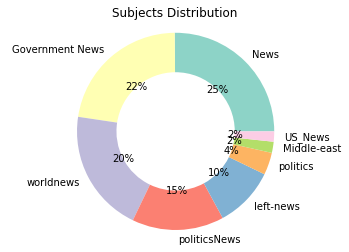

In [23]:
import seaborn as sns
colors = sns.color_palette('Set3')

plt.pie(df_top_group, labels=df_top.subject.unique(), autopct='%.0f%%', colors=colors, wedgeprops=dict(width=0.4))
plt.title('Subjects Distribution')
plt.axis('equal') 
plt.show()

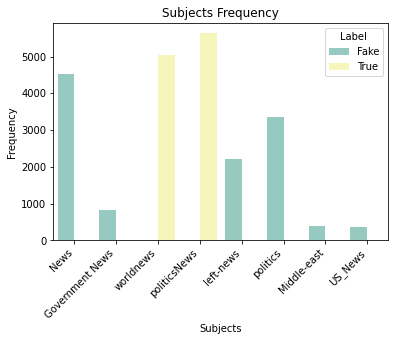

In [24]:
top_categories = df_top['subject'].value_counts().nlargest(5).index

df_top.loc[~df_top['subject'].isin(top_categories), 'subject'] = 'Other'
df_top=df_train.copy()
colors = sns.color_palette('Set3')

sns.countplot(x='subject', hue='Label', data=df_top, palette=colors)
plt.title('Subjects Frequency')
plt.xlabel('Subjects')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  
plt.legend(title='Label')  
plt.show()

In [25]:
df_train.loc[df_train['subject']=="politicsNews","Label"].unique()

array(['True'], dtype=object)

In [26]:
y= df_train['Label']
X=df_train.drop(['Label', "date",'index'], axis=1)

In [27]:
y.unique()

array(['Fake', 'True'], dtype=object)

In [28]:
X

,title,text,subject
0,"If You’re Looking For Ways To Irritate Trump,...",It s been a well-known fact for quite some tim...,News
1,BREAKING: WHY DID MASSACHUSETTS OFFICIALS WAIT...,Where was the media coverage when this black t...,Government News
2,Husband of far-right AfD co-leader to quit par...,"DUESSELDORF, Germany - Marcus Pretzell, a seni...",worldnews
3,Even Trump’s Own Ex-Organizer Accuses Him Of ...,"Just a day before the Iowa caucuses, a former ...",News
4,Pope's comments on Trump's Christianity spark ...,- Pope Francis’s remarks on Thursday that U.S....,politicsNews
...,...,...,...
22373,Istanbul's Ataturk airport reopens after jet c...,ANKARA - Istanbul s main Ataturk airport was r...,worldnews
22374,BALTIMORE PURGES CONFEDERATE STATUES In Dark O...,In a city whose former Mayor Stephanie Rawling...,politics
22375,Indigenous protesters seize oil wells in Peruv...,LIMA - Villagers in the Peruvian Amazon have s...,worldnews
22376,Clinton enjoys solid lead in early voting: Reu...,NEW YORK - With 11 days to go before the U.S. ...,politicsNews


In [29]:
port_stemmer= PorterStemmer()

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Наталья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
def stemmer(content):
    stemmed_content=re.sub('[^a-zA-Z]',' ', content)
    stemmed_content= stemmed_content.lower()
    stemmed_content= stemmed_content.split()
    stemmed_content= [port_stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content= ' '.join(stemmed_content)
    return stemmed_content

In [32]:
X['text']= X['text'].apply(stemmer)

In [33]:
X=X['text']

In [34]:
X

0        well known fact quit time donald trump handl c...
1        media coverag black thug shot white polic offi...
2        duesseldorf germani marcu pretzel senior membe...
3        day iowa caucus former field organ republican ...
4        pope franci remark thursday u republican presi...
                               ...                        
22373    ankara istanbul main ataturk airport reopen tr...
22374    citi whose former mayor stephani rawl blake to...
22375    lima villag peruvian amazon shut least oil wel...
22376    new york day go u presidenti elect democrat no...
22377    beij skyscrap fire northern chines port citi t...
Name: text, Length: 22378, dtype: object

In [35]:
df_before= df_train.drop(['Label', "date",'index'], axis=1)
df_before = df_before['text']
df_before

0        It s been a well-known fact for quite some tim...
1        Where was the media coverage when this black t...
2        DUESSELDORF, Germany - Marcus Pretzell, a seni...
3        Just a day before the Iowa caucuses, a former ...
4        - Pope Francis’s remarks on Thursday that U.S....
                               ...                        
22373    ANKARA - Istanbul s main Ataturk airport was r...
22374    In a city whose former Mayor Stephanie Rawling...
22375    LIMA - Villagers in the Peruvian Amazon have s...
22376    NEW YORK - With 11 days to go before the U.S. ...
22377    BEIJING - A skyscraper fire in the northern Ch...
Name: text, Length: 22378, dtype: object

In [36]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter



In [37]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Наталья\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return []

In [39]:
X_graphs = X.apply(tokenize_text)

In [40]:
df_before_graphs = df_before.apply(tokenize_text)

In [41]:
X_graphs

0        [well, known, fact, quit, time, donald, trump,...
1        [media, coverag, black, thug, shot, white, pol...
2        [duesseldorf, germani, marcu, pretzel, senior,...
3        [day, iowa, caucus, former, field, organ, repu...
4        [pope, franci, remark, thursday, u, republican...
                               ...                        
22373    [ankara, istanbul, main, ataturk, airport, reo...
22374    [citi, whose, former, mayor, stephani, rawl, b...
22375    [lima, villag, peruvian, amazon, shut, least, ...
22376    [new, york, day, go, u, presidenti, elect, dem...
22377    [beij, skyscrap, fire, northern, chines, port,...
Name: text, Length: 22378, dtype: object

In [42]:
X_str = [' '.join(doc) for doc in X_graphs]

In [43]:
X_str

['well known fact quit time donald trump handl critic particularli well becom glaringli obviou ten month tenur presid unit state skin thinner would need carri around bucket rememb man file billion libel lawsuit author timothi brien caus actual malic claim trump multi millionair billionair sinc offic presid trump fixat size exagger size crowd present inaugur public appear size manhattan penthous trump tower even height build matter trump small man stand around although say save legal ramif clear cut napoleon complex peopl give trump hard time size hand sinc spi magazin dub short finger vulgarian refer size candid trump hand gather steam presidenti campaign someth stuck craw day presid still feel need justifi hand size hand big said attempt put pair latex glove serv meal earli septemb affect hurrican harvey houston one man could affect claim small hand would feel entir bodi small exactli know yet peopl photoshop trump appear small photo hilari effect get skin result brilliant sever appro

In [44]:
df_before_graphs_str = [' '.join(doc) for doc in df_before_graphs]

In [45]:
df_before_graphs_str

['It s been a well-known fact for quite some time that Donald Trump doesn t handle criticism particularly well , but what has become glaringly obvious during his ten-month tenure as the President of the United States is that if his skin were any thinner , he would need to be carried around in a bucket . Remember , this is the same man who filed a $ 5 billion libel lawsuit against author Timothy O Brien for causing actual malice by claiming that Trump was only a multi-millionaire , not a billionaire.Since he s been in office , President Trump has had a fixation on size , from exaggerating the size of the crowd present at his inauguration and other public appearances , to that of the size of his Manhattan penthouse in Trump Tower and even the height of the building itself for that matter.Trump is not a small man , standing around 6 1 , although I ll say 6 2 to save myself from any legal ramifications , but he does have a clear-cut Napoleonic complex.People have been giving Trump a hard t

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
count_vectorizer_unigrams = CountVectorizer(ngram_range=(1, 1))
count_vectorizer_bigrams = CountVectorizer(ngram_range=(2, 2))

# Преобразование текста в матрицы униграмм и биграмм
X_unigrams = count_vectorizer_unigrams.fit_transform(df_before_graphs_str)
X_bigrams = count_vectorizer_bigrams.fit_transform(df_before_graphs_str)

# Получение списка уникальных униграмм и биграмм
feature_names_unigrams = count_vectorizer_unigrams.get_feature_names_out()
feature_names_bigrams = count_vectorizer_bigrams.get_feature_names_out()

# Вычисление частот униграмм и биграмм
total_counts_unigrams = X_unigrams.sum(axis=0).A1
total_counts_bigrams = X_bigrams.sum(axis=0).A1

# Создание DataFrame для униграмм и биграмм с их частотой
df_unigrams = pd.DataFrame({'Unigram': feature_names_unigrams, 'Frequency': total_counts_unigrams})
df_bigrams = pd.DataFrame({'Bigram': feature_names_bigrams, 'Frequency': total_counts_bigrams})

top_unigrams = df_unigrams.nlargest(15, 'Frequency')
top_bigrams = df_bigrams.nlargest(15, 'Frequency')

# Вывод результатов
print("Топ-10 униграмм до обработки текста")
print(top_unigrams)
print("\nТоп-10 биграмм до обработки текста")
print(top_bigrams)


Топ-10 униграмм до обработки текста
      Unigram  Frequency
80805     the     511777
81793      to     266836
58842      of     220702
8561      and     204594
41010      in     176434
80779    that     119911
59215      on      95736
32580     for      86132
42726      is      82906
83064   trump      66909
42912      it      65994
37830      he      65815
71240    said      65560
88853    with      59122
87529     was      57993

Топ-10 биграмм до обработки текста
                Bigram  Frequency
1119028         of the      50674
801047          in the      40505
1645736         to the      24885
1137202         on the      17787
627796         for the      15634
131917         and the      13165
502601    donald trump      13132
1636552          to be      13119
1579303       that the      12494
181210          at the      11867
1803927       with the      11714
1598582     the united      10588
290525          by the      10360
650570        from the       9538
1699258  united st

In [53]:
count_vectorizer_unigrams = CountVectorizer(ngram_range=(1, 1))
count_vectorizer_bigrams = CountVectorizer(ngram_range=(2, 2))

# Преобразование текста в матрицы униграмм и биграмм
X_unigrams = count_vectorizer_unigrams.fit_transform(X_str)
X_bigrams = count_vectorizer_bigrams.fit_transform(X_str)

# Получение списка уникальных униграмм и биграмм
feature_names_unigrams = count_vectorizer_unigrams.get_feature_names_out()
feature_names_bigrams = count_vectorizer_bigrams.get_feature_names_out()

# Вычисление частот униграмм и биграмм
total_counts_unigrams = X_unigrams.sum(axis=0).A1
total_counts_bigrams = X_bigrams.sum(axis=0).A1

# Создание DataFrame для униграмм и биграмм с их частотой
df_unigrams = pd.DataFrame({'Unigram': feature_names_unigrams, 'Frequency': total_counts_unigrams})
df_bigrams = pd.DataFrame({'Bigram': feature_names_bigrams, 'Frequency': total_counts_bigrams})

top_unigrams_cleaned = df_unigrams.nlargest(15, 'Frequency')
top_bigrams_cleaned = df_bigrams.nlargest(15, 'Frequency')

# Вывод результатов
print("Топ-10 униграмм после обработки текста")
print(top_unigrams_cleaned)
print("\nТоп-10 биграмм после обработки текста")
print(top_bigrams_cleaned)

Топ-10 униграмм после обработки текста
          Unigram  Frequency
57820       trump      67346
49068        said      65560
53532       state      31897
44263      presid      30405
62887       would      27408
42477       peopl      20964
63727        year      20723
47161  republican      19882
40581         one      19612
49626         say      18344
38548         new      15817
16147       elect      15689
1692         also      15617
21540      govern      15435
32115        like      15217

Топ-10 биграмм после обработки текста
                  Bigram  Frequency
513375      donald trump      13187
1825766       unit state       9522
1908369       white hous       7577
788209   hillari clinton       4922
1150327         new york       4784
631967       featur imag       4080
1321907    presid donald       3516
1807798      twitter com       3264
1163463      north korea       3260
826045          imag via       3156
1274627      pic twitter       3057
156465      barack obama  